In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import glob
import re
import os

In [2]:
def read_lvm(filename):
    ''' Take filename of *.lvm file and return data frame. '''
    
    df = pd.read_csv(filename, skiprows=22, delimiter='\t')
    
    df.columns=['t', 'V', 'COMMENTS']
    df = df.drop(['COMMENTS'], axis=1)
    
    return df

In [3]:
for filename in glob.glob('*calibration*'):
    mass = float(re.search(r'\d{1,3}', filename).group())
    
    df = read_lvm(filename)
    voltage = df['V'].mean()
    
    print('{:.5f}: {:.1f}'.format(voltage * 1000., mass))
    

101.08865: 0.0
100.61371: 100.0
101.03857: 10.0
100.14456: 200.0
100.98906: 20.0
100.84752: 50.0


In [80]:
calibration_data = pd.DataFrame({
    'm': [0.0, 10.0, 20.2, 50.0, 99.8, 200.2],
    'V': [
            0.10108865,
            0.10103857,
            0.10098906,
            0.10084752,
            0.10061371,
            0.10014456
        ]
})

m, b = np.polyfit(calibration_data['V'],
                  calibration_data['m'], 1)

calibration_data['m_pred'] = m * calibration_data['V'] + b
calibration_data['d'] = np.abs(calibration_data['m'] - calibration_data['m_pred'])

calibration_data['d'].mean()

def voltage_to_mass(v):
    ''' Return mass for a given voltage. '''
    
    return m * v + b

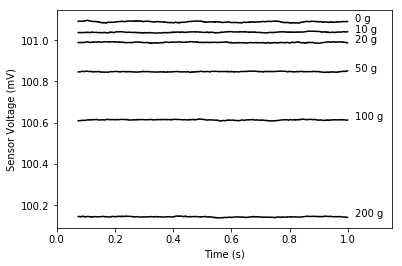

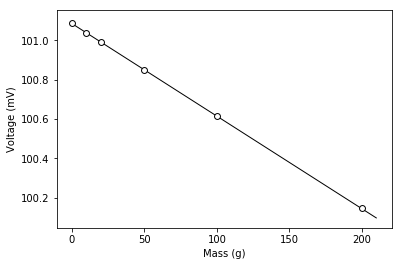

In [38]:
sample_rate = 1000 # Hz

x = []
y = []

for file in glob.glob('*calibration*'):
    df = read_lvm(file)
    
    value, = re.search(r'(\d{1,3})', file).groups()

    plt.plot(df['t'], df['V'].rolling(75).mean() * 1000.0, c='k')
    plt.text(1.025, df['V'].mean() * 1000, value + ' g')
    
    x.append(float(value))
    y.append(df['V'].mean() * 1000)

plt.xlabel('Time (s)')
plt.ylabel('Sensor Voltage (mV)')
plt.xlim((0, 1.15))
    
plt.show()


plt.scatter(x, y, c='w', edgecolor='k', s=35)

m, b = np.polyfit(x, y, 1)

xs = np.linspace(0, 210, 1000)
ys = m * xs + b

plt.plot(xs, ys, color='k', linewidth=1, zorder=0)
plt.ylabel('Voltage (mV)')
plt.xlabel('Mass (g)')
plt.show()



-212448.39994210273 21475.40603019604


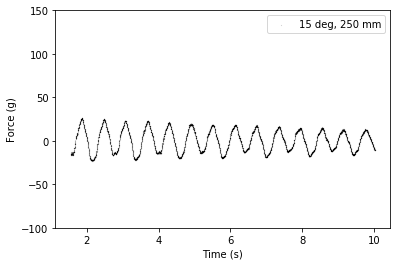

-212448.39994210273 21475.40603019604


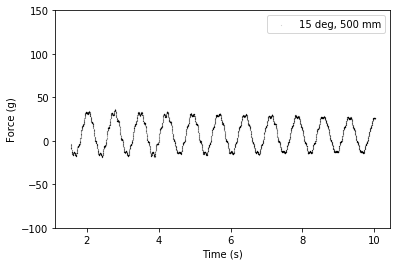

-212448.39994210273 21475.40603019604


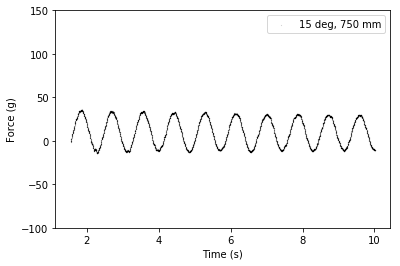

-212448.39994210273 21475.40603019604


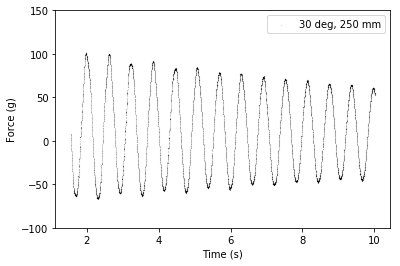

-212448.39994210273 21475.40603019604


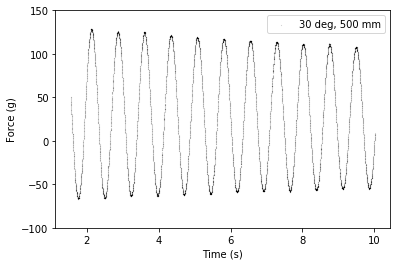

-212448.39994210273 21475.40603019604


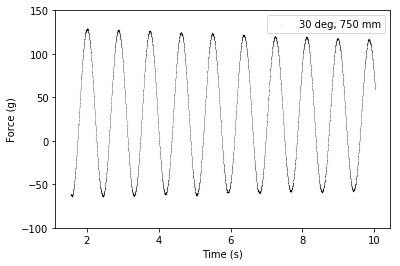

-212448.39994210273 21475.40603019604


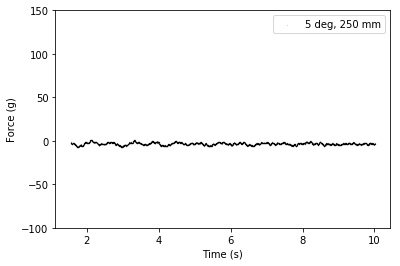

-212448.39994210273 21475.40603019604


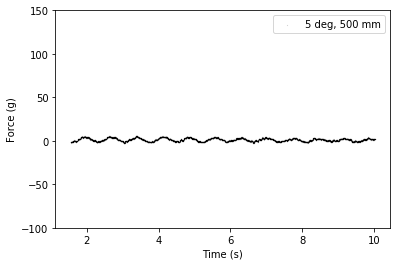

-212448.39994210273 21475.40603019604


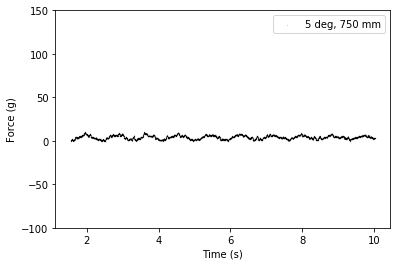

In [115]:
for filename in glob.glob('data*'):
    f = 1000
    
    angle, displacement = re.search(r'data_(\d{1,2})_deg_at_(\d{3})', filename).groups()

    df = pd.read_csv(filename, delimiter='\t', skiprows=23, names=['T', 'V', 'C'])
    df['T'] = df['T'] / 1000
    df = df.drop(columns=['C'])

    df['F'] = voltage_to_mass(df['V'])

    print(m, b)

    start = 1.5
    plt.scatter(df[df['T'] > start]['T'], df[df['T']> start]['F'].rolling(50).mean(), color='k', s=(1/256), label='%s deg, %s mm' % (angle, displacement))
    plt.ylim((-100, 150))
    plt.xlabel('Time (s)')
    plt.ylabel('Force (g)')
    plt.legend()
    plt.show()

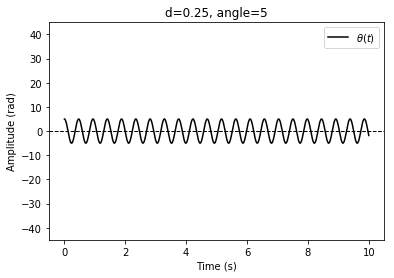

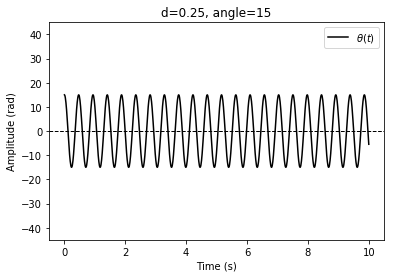

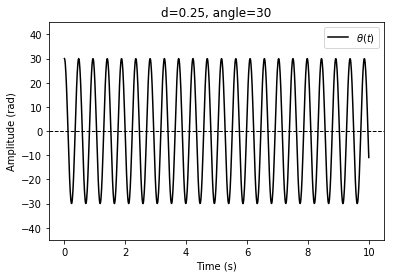

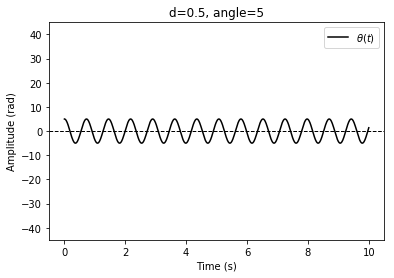

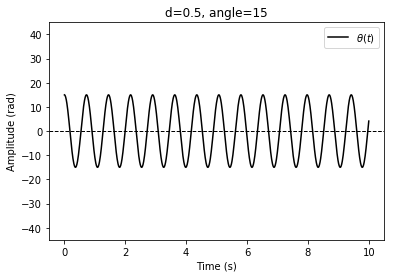

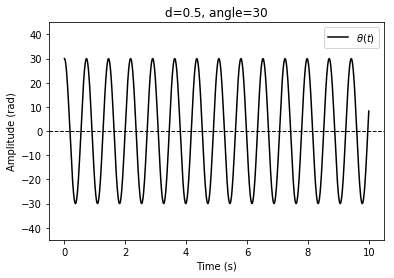

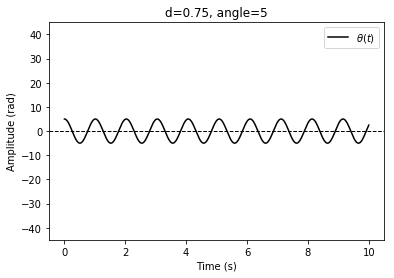

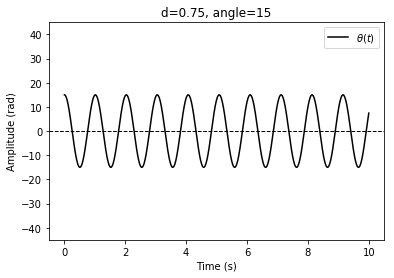

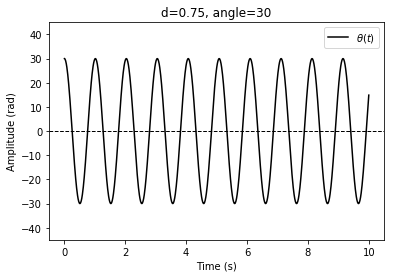

In [128]:
m_R1     = 0.0049 # [kg]
m_R2     = 0.0933 # [kg]

m_wing   = 0.0031 # [kg]
m_fender = 0.0081 # [kg]

m_T      = 0.0169 # [kg]
m_B      = 0.3822 # [kg]

d_R1 = 0.0325 # [m]
d_R2 = 0.4910 # [m]
d_T  = 0.0670 # [m]

L_R1 = 0.0470 # [m]
L_R2 = 0.9330 # [m]
L_B  = 0.0370 # [m]

def I_rod(L, m, d):
    ''' Return moment of inertia for slender rod of lenght L 
        with a center of mass d from the fixed point. '''
    
    Ic  = (1/12)*m*L**2
    Ifp = Ic + m*d**2
    
    return Ifp


def I_point(m, d):
    ''' Return moment of ineratia for points mass. '''
    
    return m*d**2


def I_block(s, m, d):
    ''' Return moment of inertia for block of side length s. '''
    
    Ic  = (1/6)*m*s**2
    Ifp = Ic + m*d**2
    
    return Ifp


def Io_point(d):
    ''' Return point-mass inertia for pendulum. '''
    
    return I_point(m=(2*(m_wing + m_fender) + m_B), d=d)


def Io_real(d):
    ''' Return realistic inertia for the pendulum. '''
    
    return sum([
        I_rod(L=L_R1, m=m_R1, d=d_R1),
        I_rod(L=L_R2, m=m_R2, d=d_R2),
        I_point(m=m_T, d=d_T),
        I_block(s=L_B, m=(2*(m_wing + m_fender) + m_B), d=d)
    ])


def model(x, t, I, c=0, small_angle_approximation=False, g=9.81):
    ''' Return integrals for pendulum model. 
    
        Args:
        
            I (float):  system inertia
            c (float):  damping coefficient
            g (float):  gravitational acceleration
    '''
    
    theta, omega = x
    
    if small_angle_approximation:
        alpha = (-c * omega - g * theta) / I
    else:
        alpha = (-c * omega - g * np.sin(theta)) / I
        
    return [omega, alpha]



for d in [0.250, 0.500, 0.750]:
    for angle in [5, 15, 30]:
        x0 = [angle * np.pi / 180, 0.0]
        t  = np.linspace(0, 10, 1000)

        sol = odeint(model, x0, t, args=(Io_real(d), 0, True, 9.81))

        plt.axhline(0, linestyle='--', c='k', linewidth=1)

        plt.plot(t, sol[:,0] * 180 / np.pi, 'k', label=r'$\theta(t)$')
        #plt.plot(t, sol[:,1], 'grey', label=r'$\omega(t)$')

        plt.legend()

        plt.title('d=%s, angle=%s' % (d, angle))
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (rad)')
        
        plt.ylim((-45, 45))

        plt.show()    
    